# **CS4774 Final Project**: SARS-CoV-2 CT Scan Prediction
Chengyuan Cai, Tiancheng Ren, Yuchen Sun, Yanwen Wang

Import Module

In [ ]:
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import metrics
import cv2

from sklearn.svm import SVC

import tensorflow as tf
import progressbar
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sys
import pandas as pd
import keras
import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Loading Module**

In [ ]:
def get_data(datafile):
  x, y = [], []
  for dir in os.listdir(datafile):
    full_dir = osp.join(datafile,dir)
    print('loading',dir)
    content = os.listdir(full_dir)
    for i in progressbar.progressbar(range(len(content))):
      img = content[i]
      original = cv2.imread(osp.join(full_dir,img), cv2.IMREAD_GRAYSCALE)
      img_array = cv2.resize(original,(200,200))
      img_array = (img_array.flatten())
      img_array = img_array.reshape(-1,1).T.flatten()
      if dir == 'COVID':
        y.append(1)
      else:
        y.append(0)
      x.append(img_array)
  print('loading finished\n')
  x, y = np.array(x), np.array(y)
  return x, y

In [ ]:
def load_single_img(img_dir):
  original = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
  img_array = cv2.resize(original,(200,200))
  img_array = (img_array.flatten())
  img_array = img_array.reshape(-1,1).T.flatten()
  return img_array

In [ ]:
def processData():
    xtrain, ytrain = get_data('/content/drive/My Drive/template/archive/')
    xtest, ytest = get_data('/content/drive/My Drive/template/test_sample/')
    
    return xtrain, xtest, ytrain, ytest

**MLP MODEL**


In [ ]:
def create_mlp(args=None):
  model = keras.Sequential(
      [
       keras.layers.Flatten(input_shape=(200, 200)),
       keras.layers.Dropout(0.2),
       keras.layers.Dense(512, activation="relu"),
       keras.layers.Dropout(0.2),
       keras.layers.Dense(10, activation=("sigmoid")),
       ]
       )
  print(model.summary())

  model.compile(
      optimizer = "adadelta",
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=["accuracy"],
      )
  return model

def train_mlp(x_train, y_train, x_vali=None, y_vali=None, args=None):
    y_train = keras.utils.to_categorical(y_train, num_classes=10)
    model = create_mlp(args)
    history = model.fit(x_train, y_train,
                        batch_size=args['batch_size'],
                        epochs=args['epochs'],
                        verbose=1,
                        validation_split=args['validation_split'])
    return model, history

def train_and_select_model(train_csv):
    x_train, y_train = get_data(train_csv)
    get_weight(x_train, y_train)

    args = {
        'learning_rate': 0.001,
        'batch_size': 64,
        'epochs': 30,
        'validation_split': 0.1
    }
    model, history = train_mlp(x_train, y_train, x_vali=None, y_vali=None, args=args)

    validation_accuracy = history.history['val_accuracy']

    return model, history

In [ ]:
def plot_history(history):
    train_loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']

    train_acc_history = history.history['accuracy']
    val_acc_history = history.history['val_accuracy']

    # plot
    print(train_loss_history)

    plt.title('training loss & validation loss')
    plt.plot(list(range(len(train_loss_history))), train_loss_history, label='train loss history')
    plt.legend()
    plt.plot(list(range(len(val_loss_history))), val_loss_history, label='val_loss history')
    plt.legend()
    plt.show()

    plt.title('training accuracy & validation accuracy')
    plt.plot(list(range(len(train_acc_history))), train_acc_history, label='train acc histroy')
    plt.legend()
    plt.plot(list(range(len(val_acc_history))), val_acc_history, label='val acc history')
    plt.legend()
    plt.show()

Run MLP

  2% (30 of 1178) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

loading non-COVID


100% (1178 of 1178) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
  2% (31 of 1212) |                      | Elapsed Time: 0:00:00 ETA:   0:00:05

loading COVID


100% (1212 of 1212) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


loading finished



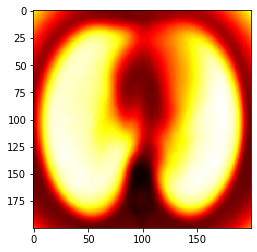

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               20480512  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 20,485,642
Trainable params: 20,485,642
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
34/34 [==============================] - 0s 14ms/step - loss: 49.3290 - accuracy: 0.2241 - v

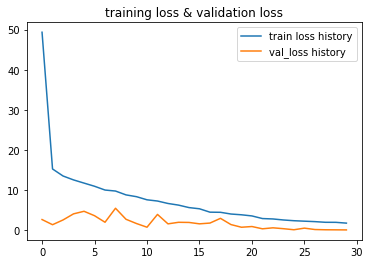

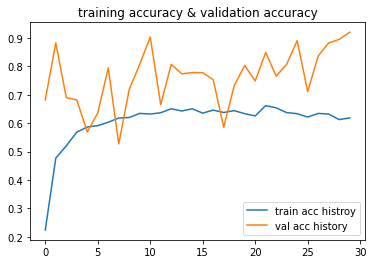

In [ ]:
# RUN MLP
# MLP (RTC)
train_file = '/content/drive/My Drive/template/archive/'
mlp_model, mlp_history = train_and_select_model(train_file)
plot_history(mlp_history)

**CNN MODEL**

In [ ]:
def create_cnn(args=None):
    input_shape = (200, 200, 1)

    # Define model architecture
    model = Sequential()
    model.add(Conv2D(filters= 30, activation= 'relu', kernel_size=(3,3) , strides= (1,1), input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2) , strides=2))
    model.add(Conv2D(filters= 60, activation= 'relu', kernel_size=(3,3) , strides= (1,1)))
    model.add(MaxPooling2D(pool_size=(2,2) , strides=2))
    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid' ))
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.summary()

    # Compile
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

def train_model(x_train, y_train, validation_split=0.1, args=None):
    x_train = x_train.reshape(-1, 200, 200, 1)
    model = create_cnn(args)
    history = model.fit(x_train,y_train,epochs=args['epochs'],batch_size=args['batch_size'],verbose=1,validation_split=validation_split)

    return model, history
  
def train_and_select_model_cnn(x_train, y_train):
    args = {
        'learning_rate': 0.0001,
        'batch_size': 64,
        'epochs': 30,
        'validation_split': 0.1
    }
    best_model, best_history = train_model(x_train, y_train, args=args)
      
    return best_model, best_history


Run CNN

  2% (30 of 1178) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

loading non-COVID


100% (1178 of 1178) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
  2% (31 of 1212) |                      | Elapsed Time: 0:00:00 ETA:   0:00:05

loading COVID


100% (1212 of 1212) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
 57% (29 of 50) |#############           | Elapsed Time: 0:00:00 ETA:   0:00:00

loading finished

loading COVID


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 64% (33 of 51) |###############         | Elapsed Time: 0:00:00 ETA:   0:00:00

loading non-COVID


100% (51 of 51) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


loading finished

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 30)      300       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 30)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 60)        16260     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 60)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 138240)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 138241    
Total params: 154,801
Trainable params: 154,801
Non-trainable params: 0
______________________________

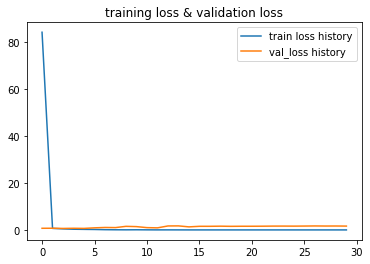

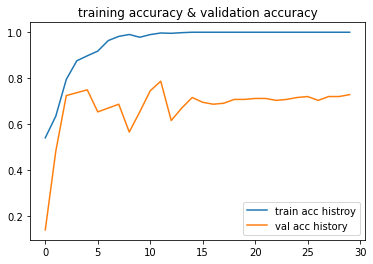

In [ ]:
# RUN CNN
# CNN (CCY)
xtrain, xtest, ytrain, ytest = processData()
xtest = xtest.reshape(-1, 200, 200, 1)
model, history = train_and_select_model_cnn(xtrain, ytrain)
loss_test, acc_test = model.evaluate(xtest, ytest)
plot_history(history)

**ResNet MODEL**

In [ ]:
def shuff(a, b):
    indices = np.arange(a.shape[0])
    np.random.shuffle(indices)
    return a[indices], np.array(b)[indices]

In [ ]:
def create_resnet50(x, y, args = None):
  x, y = shuff(x, y)
  resnet_model = keras.applications.ResNet50(include_top=False, weights = 'imagenet', input_shape = (200, 200, 3))
  Model = keras.models.Sequential()
  Model.add(resnet_model)
  Model.add(Flatten())
  Model.add(keras.layers.BatchNormalization())
  Model.add(keras.layers.Dense(256, activation= 'relu'))
  Model.add(keras.layers.Dropout(0.5))
  Model.add(keras.layers.BatchNormalization())
  Model.add(keras.layers.Dense(64, activation = 'relu'))
  Model.add(keras.layers.Dropout(0.3))
  Model.add(keras.layers.BatchNormalization())
  Model.add(keras.layers.Dense(1, activation='sigmoid'))

  Model.compile(optimizer=args['optimization'],loss=args['loss'],metrics=['accuracy'])
  Model.summary()
  history = Model.fit(x, y, batch_size=args['batch_size'],validation_data = (x_test_re_stack, y_test_re) , epochs=args['epoch'], verbose=1,
                      callbacks=[checkpoint])

  return history

In [ ]:
def create_resnet101(x, y, args = None):

  x, y = shuff(x, y)
  resnet_model = keras.applications.ResNet101(include_top=False, weights = 'imagenet', input_shape = (200, 200, 3))
  Model = keras.models.Sequential()
  Model.add(resnet_model)
  Model.add(Flatten())
  Model.add(keras.layers.BatchNormalization())
  Model.add(keras.layers.Dense(512, activation= 'relu'))
  Model.add(keras.layers.Dropout(0.5))
  Model.add(keras.layers.BatchNormalization())
  Model.add(keras.layers.Dense(64, activation = 'relu'))
  Model.add(keras.layers.Dropout(0.5))
  Model.add(keras.layers.BatchNormalization())
  Model.add(keras.layers.Dense(1, activation='sigmoid'))

  Model.compile(optimizer=args['optimization'],loss=args['loss'],metrics=['accuracy'])
  Model.summary()
  history = Model.fit(x, y, batch_size=args['batch_size'],validation_data = (x_test_re_stack, y_test_re) , epochs=args['epoch'], verbose=1,
                      callbacks=[checkpoint])

  return history

In [ ]:
def create_resnet152(x, y, args = None):

  x, y = shuff(x, y)
  resnet_model = keras.applications.ResNet152(include_top=False, weights = 'imagenet', input_shape = (200, 200, 3))
  Model = keras.models.Sequential()
  Model.add(resnet_model)
  Model.add(Flatten())
  Model.add(keras.layers.BatchNormalization())
  Model.add(keras.layers.Dense(512, activation= 'relu'))
  Model.add(keras.layers.Dropout(0.5))
  Model.add(keras.layers.BatchNormalization())
  Model.add(keras.layers.Dense(64, activation = 'relu'))
  Model.add(keras.layers.Dropout(0.5))
  Model.add(keras.layers.BatchNormalization())
  Model.add(keras.layers.Dense(1, activation='sigmoid'))

  Model.compile(optimizer=args['optimization'],loss=args['loss'],metrics=['accuracy'])
  Model.summary()
  history = Model.fit(x, y, batch_size=args['batch_size'],validation_data = (x_test_re_stack, y_test_re) , epochs=args['epoch'], verbose=1,
                      callbacks=[checkpoint])

  return history

In [ ]:
def plotResNetAcc(hist):
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def plotResNetLoss(hist):
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

Run ResNet

In [ ]:
# RUN ResNet
# ResNet (WYW)
xtrain, xtest, ytrain, ytest = processData()
x_train_re = xtrain.reshape(-1, 200, 200)
y_train_re = ytrain.reshape(len(ytrain), 1)

x_test_re = xtest.reshape(-1, 200, 200)
y_test_re = ytest.reshape(len(ytest),1)

x_train_re_stack = np.stack((x_train_re,)*3, axis=-1)
x_test_re_stack = np.stack((x_test_re,)*3, axis=-1)

checkpoint_path = "training_1/cp2.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, monitor='val_accuracy', save_best_only=True, save_weights_only=True)

args = {
    'optimization': keras.optimizers.RMSprop(learning_rate=2e-5, momentum=0.9),
    'loss': 'binary_crossentropy',
    'epoch': 30,
    'batch_size': 32,
    'validation_split': 0.3
}

history = create_resnet152(x_train_re_stack, y_train_re, args=args)


  1% (14 of 1178) |                      | Elapsed Time: 0:00:00 ETA:   0:00:08

loading non-COVID


100% (1178 of 1178) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
  2% (31 of 1212) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

loading COVID


100% (1212 of 1212) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
 39% (20 of 51) |#########               | Elapsed Time: 0:00:00 ETA:   0:00:00

loading finished

loading non-COVID


100% (51 of 51) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 56% (28 of 50) |#############           | Elapsed Time: 0:00:00 ETA:   0:00:00

loading COVID


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


loading finished

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 

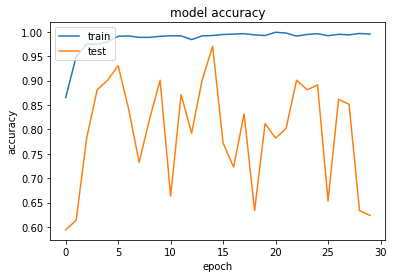

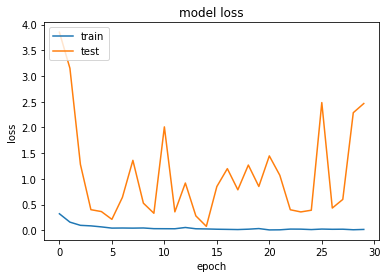

4/4 [==============================] - 0s 114ms/step - loss: 0.0765 - accuracy: 0.9703
[0.07652979344129562, 0.9702970385551453]


In [ ]:
plotResNetAcc(history)
plotResNetLoss(history)
history.model.load_weights(checkpoint_path)
print(history.model.evaluate(x_test_re_stack, y_test_re))

**KNN MODEL**

In [ ]:
def KNN():
  k_range = range(1,9)
  scores = {}
  scores_list = []
  for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))
  return scores_list


Run KNN

  2% (30 of 1178) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

loading non-COVID


100% (1178 of 1178) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
  2% (31 of 1212) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

loading COVID


100% (1212 of 1212) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
 34% (17 of 50) |########                | Elapsed Time: 0:00:00 ETA:   0:00:00

loading finished

loading COVID


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 62% (32 of 51) |###############         | Elapsed Time: 0:00:00 ETA:   0:00:00

loading non-COVID


100% (51 of 51) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


loading finished

[0.7326732673267327, 0.693069306930693, 0.7326732673267327, 0.6633663366336634, 0.6831683168316832, 0.6633663366336634, 0.7128712871287128, 0.6732673267326733]


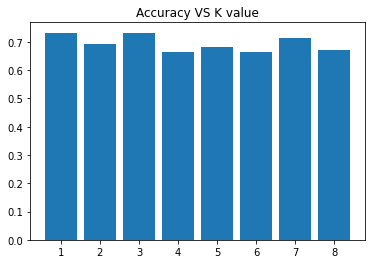

In [ ]:
# RUN KNN
# KNN (CCY)
X_train, X_test, y_train, y_test = processData()
klist = [1,2,3,4,5,6,7,8]
accuracy_list = KNN()
print(accuracy_list)
plt.bar(klist,accuracy_list)
plt.title("Accuracy VS K value")
plt.show()

**SVM MODEL**

In [ ]:
def fold(x, y, i, nfolds):
  sx, sy = sklearn.utils.shuffle(x,y)
  ind = np.array_split(np.arange(sx.shape[0]),nfolds)[i]
  x_vali, y_vali = sx[ind,:], sy[ind]
  x_train, y_train = np.delete(sx,ind,0), np.delete(sy,ind)
  return x_train, y_train, x_vali, y_vali


In [ ]:
def train_select_model_svm(x_train, y_train, nfolds):
  param_set = [{'kernel': 'poly', 'C': 0.5, 'degree': 7}]
  best_params = {}
  best_acc = 0
  for p in param_set:
    print('parameter:',p)
    kernel, C, degree = p['kernel'], p['C'], p['degree']
    accs, train_accs = [], []
    for i in range(nfolds):
      xtrain, ytrain, xvali, yvali = fold(x_train, y_train, i, nfolds)
      clf = SVC(kernel=kernel, C=C, degree=degree, gamma='scale').fit(xtrain, ytrain)
      train_acc = clf.score(xtrain, ytrain)
      acc = clf.score(xvali, yvali)
      train_accs.append(train_acc)
      accs.append(acc)
    accuracy = sum(accs)/len(accs)
    train_accuracy = sum(train_accs)/len(train_accs)
    print('training accuracy:',train_accuracy)
    print('testing accuracy:',accuracy)
    if accuracy > best_acc:
      best_params, best_acc = p, accuracy
      print('current best:', p, accuracy)
    
  best_score = best_acc
  best_model = SVC(kernel=best_params['kernel'], C=best_params['C'], degree=best_params['degree'], gamma='scale').fit(x_train,y_train)

  return best_model, best_score


Run SVM

In [ ]:
# RUN SVM
# SVM (SYC)
FOLD = 5

xtrain, xtest, ytrain, ytest = processData()
best_model, best_score = train_select_model_svm(xtrain, ytrain, FOLD)

acc = best_model.score(xtest, ytest)
print('SVM MODEL ACC:', acc)

loading non-COVID


100% (1178 of 1178) |####################| Elapsed Time: 0:07:08 Time:  0:07:08
N/A% (0 of 1212) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

loading COVID


100% (1212 of 1212) |####################| Elapsed Time: 0:06:10 Time:  0:06:10


loading finished

loading COVID


100% (50 of 50) |########################| Elapsed Time: 0:00:14 Time:  0:00:14
N/A% (0 of 51) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

loading non-COVID


100% (51 of 51) |########################| Elapsed Time: 0:00:20 Time:  0:00:20


loading finished

parameter: {'kernel': 'poly', 'C': 0.5, 'degree': 7}
training accuracy: 1.0
testing accuracy: 0.889958158995816
current best: {'kernel': 'poly', 'C': 0.5, 'degree': 7} 0.889958158995816
SVM MODEL ACC: 0.7128712871287128


**OUR MODEL**

In [ ]:
def get_weight(x, y, color='hot'):
  covid_img = np.array([x[i,:] for i in range(len(y)) if y[i]])
  noncovid_img = np.array([x[i,:] for i in range(len(y)) if not y[i]])
  covid_weight = np.array([sum(covid_img[:,i]) for i in range(covid_img.shape[1])]).reshape(200,200)/covid_img.shape[1]
  noncovid_weight = np.array([sum(noncovid_img[:,i]) for i in range(noncovid_img.shape[1])]).reshape(200,200)/noncovid_img.shape[1]

  covid_hotspot = np.max(covid_weight)-covid_weight
  noncovid_hotspot = np.max(noncovid_weight)-noncovid_weight
  weight = (covid_hotspot+noncovid_hotspot)/2
  plt.imshow(weight,cmap=color,interpolation='nearest')
  plt.show()

  return weight

def get_edges(img_array, threshold):
  minim, maxim = threshold
  edges = cv2.Canny(img_array,minim,maxim)
  return (edges/255).flatten()


In [ ]:
def our_model_predict(x_test, y_test, weight, threshold, models, params):
  e_val, m_val, v_val, s_val, b_val, fraction, number, show = params
  minim, maxim = threshold
  
  covid_model, noncovid_model = models
  laplacian = np.array([[0,1,0],[1,-4,1],[0,1,0]])
  y_predict = []

  for i in progressbar.progressbar(range(x_test.shape[0])):
    covid_score, noncovid_score = 0, 0
    img = x_test[i,:].reshape(200,200)
    edge_info = cv2.Canny(img,minim,maxim)

    covid_res, noncovid_res = np.zeros(5), np.zeros(5)
    ind_flat = np.random.choice(np.arange(40000).reshape(200,200)[weight>=fraction*np.max(weight)],number)
    count = 1
    for ind in ind_flat:
      x_coord, y_coord = int(ind%200), int(ind/200)
      if 12<x_coord<188 and 12<y_coord<188:
        test_block = img[max(0,y_coord-10):min(y_coord+10,200),max(0,x_coord-10):min(x_coord+10,200)]
        block = img[max(0,y_coord-25):min(y_coord+25,200),max(0,x_coord-25):min(x_coord+25,200)]
        if not (np.std(test_block)<=50 and np.mean(test_block)>=175):
          count += 1
          block_edge = sum(get_edges(block,threshold))
          block_mean, block_var = np.mean(block), np.max(block)-np.min(block)
          block_std = np.std(block)
          block_blur = np.std(np.convolve(block.flatten(),laplacian.flatten(),mode='same'))**2
          covid_res += np.array([block_edge,block_mean,block_var,block_std,block_blur])
          noncovid_res += np.array([block_edge,block_mean,block_var,block_std,block_blur])
    covid_res, noncovid_res = covid_res/count, noncovid_res/count
    covid_score = e_val*(covid_res[0]-covid_model[0])/covid_model[0] + m_val*(covid_res[1]-covid_model[1])/covid_model[1] +\
     v_val*(covid_model[2]-covid_res[2])/covid_model[2] + s_val*(covid_res[3]-covid_model[3])/covid_model[3] + b_val*(covid_res[4]-covid_model[4])/covid_model[4]
    noncovid_score = e_val*(covid_model[0]-noncovid_res[0])/noncovid_model[0] + m_val*(covid_model[1]-noncovid_res[1])/noncovid_model[1] +\
     v_val*(noncovid_res[2]-noncovid_model[2])/noncovid_model[2] + s_val*(noncovid_res[3]-noncovid_model[3])/noncovid_model[3] + b_val*(noncovid_res[4]-noncovid_model[4])/noncovid_model[4]

    res = int(covid_score >= noncovid_score)
    y_predict.append(res)

  same = [int(y_predict[i] == y_test[i]) for i in range(len(y_predict))]
  accuracy = sum(same)/len(y_predict)
  return accuracy

In [ ]:
def our_model_visualize(image, weight, threshold, params):
  import statistics
  e_val, m_val, v_val, s_val, b_val, fraction, number, show = params
  minim, maxim = threshold

  img = load_single_img(image).reshape(200,200)
  edge_info = cv2.Canny(img,minim,maxim)
  ind_flat = np.random.choice(np.arange(40000).reshape(200,200)[weight>=fraction*np.max(weight)],number)
  p = plt.subplots(1)[1]
  p.imshow(img, cmap='gray', vmin=0, vmax=255)
  for ind in ind_flat:
    x_coord, y_coord = int(ind%200), int(ind/200)
    block = img[max(0,y_coord-10):min(y_coord+10,200),max(0,x_coord-10):min(x_coord+10,200)]
    if 12<x_coord<188 and 12<y_coord<188:
      if not (np.std(block)<=50 and np.mean(block)>=175):
        rect = patches.Rectangle((x_coord-25,y_coord-25),50,50,linewidth=2,edgecolor='r',facecolor='none')
        p.add_patch(rect)
      else:
        rect = patches.Rectangle((x_coord-25,y_coord-25),50,50,linewidth=2,edgecolor='b',facecolor='none')
        p.add_patch(rect)
  plt.show()
  

In [ ]:
def our_cross_validation(x_train, y_train, weight, threshold, params, nfolds):
  e_val, m_val, v_val, s_val, b_val, fraction, number, show = params
  minim, maxim = threshold

  vali_accs, train_accs = [], []
  for i in range(nfolds):
    print('\nCurrent fold:',i)
    xtrain, ytrain, xvali, yvali = fold(x_train, y_train, i, nfolds)
    covid_model, noncovid_model = train_select_model_our(xtrain, ytrain, weight, threshold, params)
    train_acc = our_model_predict(xtrain, ytrain, weight, threshold, (covid_model,noncovid_model), params)
    vali_acc = our_model_predict(xvali, yvali, weight, threshold, (covid_model,noncovid_model), params)
    
    train_accs.append(train_acc)
    vali_accs.append(vali_acc)
  vali_accuracy = sum(vali_accs)/len(vali_accs)
  train_accuracy = sum(train_accs)/len(train_accs)
  print()
  print('training accuracy:',train_accuracy)
  print('validation accuracy:',vali_accuracy)
  

In [ ]:
def train_select_model_our(x_train, y_train, weight, threshold, params):
  e_val, m_val, v_val, s_val, b_val, fraction, number, show = params
  covid_model, noncovid_model = np.zeros(5), np.zeros(5) #[edgeNumber,mean,var]
  minim, maxim = threshold
  laplacian = np.array([[0,1,0],[1,-4,1],[0,1,0]])
  
  for i in progressbar.progressbar(range(x_train.shape[0])):
    img = x_train[i,:].reshape(200,200)
    edge_info = cv2.Canny(img,minim,maxim)
    img_score = np.zeros(5)
    ind_flat = np.random.choice(np.arange(40000).reshape(200,200)[weight>=fraction*np.max(weight)],number)
    count = 1
    for ind in ind_flat:
      x_coord, y_coord = int(ind%200), int(ind/200)
      if 12<x_coord<188 and 12<y_coord<188:
        test_block = img[max(0,y_coord-10):min(y_coord+10,200),max(0,x_coord-10):min(x_coord+10,200)]
        block = img[max(0,y_coord-25):min(y_coord+25,200),max(0,x_coord-25):min(x_coord+25,200)]
        if not (np.std(test_block)<=50 and np.mean(test_block)>=175):
          count += 1
          block_edge = sum(get_edges(block,threshold))
          block_mean, block_var = np.mean(block), np.max(block)-np.min(block)
          block_std = np.std(block)
          block_blur = np.std(np.convolve(block.flatten(),laplacian.flatten(),mode='same'))**2
          img_score += np.array([block_edge,block_mean,block_var,block_std, block_blur])
    if y_train[i]:
      covid_model += img_score/count
    else:
      noncovid_model += img_score/count

  covid_model /= np.sum(y_train)
  noncovid_model /= (len(y_train)-np.sum(y_train))
  if show:
    print()
    print(covid_model)
    print(noncovid_model)
  return covid_model, noncovid_model


Run Our Model

  2% (30 of 1178) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

loading non-COVID


100% (1178 of 1178) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
  2% (31 of 1212) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

loading COVID


100% (1212 of 1212) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
 38% (19 of 50) |#########               | Elapsed Time: 0:00:00 ETA:   0:00:00

loading finished

loading COVID


100% (50 of 50) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 62% (32 of 51) |###############         | Elapsed Time: 0:00:00 ETA:   0:00:00

loading non-COVID


100% (51 of 51) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


loading finished



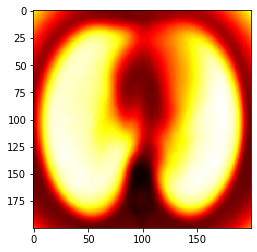

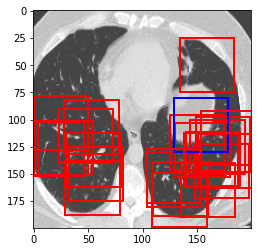

  0% (5 of 2390) |                       | Elapsed Time: 0:00:00 ETA:   0:00:55


TRAINING


100% (2390 of 2390) |####################| Elapsed Time: 0:00:49 Time:  0:00:49
  8% (9 of 101) |##                      | Elapsed Time: 0:00:00 ETA:   0:00:01


[ 184.81839792  121.68244941  174.44006904   48.97248605 7555.56774054]
[ 140.4492304   114.23116231  177.01229174   47.9619107  7330.20732148]

PREDICTING


100% (101 of 101) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


OUR MODEL ACC: 0.8514851485148515


In [ ]:
# RUN Our Model
# OUR MODEL (SYC)
FOLD = 3
THRESHOLD = (200,210)
PARAMS = [5,2,3,2,1,0.8,25,True]

xtrain, xtest, ytrain, ytest = processData()
weight = get_weight(xtrain, ytrain)

select = np.random.choice(np.array(range(1,1213)),1)[0]
our_model_visualize('/content/drive/My Drive/template/archive/COVID/Covid ('+str(select)+').png', weight, THRESHOLD, PARAMS)

print('\nTRAINING')
covid_model, noncovid_model = train_select_model_our(xtrain, ytrain, weight, THRESHOLD, PARAMS)
print('\nPREDICTING')
accuracy = our_model_predict(xtest, ytest, weight, THRESHOLD, (covid_model,noncovid_model), PARAMS)
print('OUR MODEL ACC:', accuracy)

**MAIN FUNCTION**

In [ ]:
if __name__ == '__main__':
  ALL_MODELS = ['CNN','MLP','ResNet101','KNN','SVM','OUR'] # add more
  test_model = ['OUR'] # change this
  for model in ALL_MODELS: # change to in ALL_MODELS in final submission
    if model == 'CNN':
      # CNN (CCY)
      xtrain, xtest, ytrain, ytest = processData()
      xtest = xtest.reshape(-1, 200, 200, 1)
      model, history = train_and_select_model_cnn(xtrain, ytrain)
      loss_test, acc_test = model.evaluate(xtest, ytest)
      plot_history(history)

    elif model == 'MLP':
      # MLP (RTC)
      train_file = '/content/drive/My Drive/template/archive/'
      mlp_model, mlp_history = train_and_select_model(train_file)
      plot_history(mlp_history)

    elif model == 'ResNet101':
      # ResNet (WYW)
      xtrain, xtest, ytrain, ytest = processData()
      x_train_re = x_train.reshape(-1, 200, 200)
      y_train_re = y_train.reshape(len(y_train), 1)

      x_test_re = x_test.reshape(-1, 200, 200)
      y_test_re = y_test.reshape(len(y_test),1)

      x_train_re_stack = np.stack((x_train_re,)*3, axis=-1)
      x_test_re_stack = np.stack((x_test_re,)*3, axis=-1)

      checkpoint_path = "training_1/cp2.ckpt"
      checkpoint_dir = os.path.dirname(checkpoint_path)
      checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, monitor='val_accuracy', save_best_only=True, save_weights_only=True)

      args = {
          'optimization': keras.optimizers.RMSprop(learning_rate=2e-5, momentum=0.9),
          'loss': 'binary_crossentropy',
          'epoch': 30,
          'batch_size': 32,
          'validation_split': 0.3
      }

      history =  create_resnet152(x_train_re_stack, y_train_re, args=args)
      plotResNetAcc(history)
      plotResNetLoss(history)
      history.model.load_weights(checkpoint_path)
      print(history.model.evaluate(x_test_re_stack, y_test_re))

    elif model == 'KNN':
      # KNN (CCY)
      X_train, X_test, y_train, y_test = processData()
      klist = [1,2,3,4,5,6,7,8]
      accuracy_list = KNN()
      print(accuracy_list)
      plt.bar(klist,accuracy_list)
      plt.title("Accuracy VS K value")
      plt.show()

    elif model == 'SVM':
      # SVM (SYC)
      FOLD = 5

      xtrain, xtest, ytrain, ytest = processData()
      best_model, best_score = train_select_model_svm(xtrain, ytrain, FOLD)

      acc = best_model.score(xtest, ytest)
      print('SVM MODEL ACC:', acc)

    elif model == 'OUR':
      # OUR MODEL (SYC)
      FOLD = 3
      THRESHOLD = (200,210)
      PARAMS = [5,2,3,2,1,0.8,25,True]

      xtrain, xtest, ytrain, ytest = processData()
      weight = get_weight(xtrain, ytrain)

      select = np.random.choice(np.array(range(1,1213)),1)[0]
      our_model_visualize('/content/drive/My Drive/template/archive/COVID/Covid ('+str(select)+').png', weight, THRESHOLD, PARAMS)

      print('\nTRAINING')
      covid_model, noncovid_model = train_select_model_our(xtrain, ytrain, weight, THRESHOLD, PARAMS)
      print('\nPREDICTING')
      accuracy = our_model_predict(xtest, ytest, weight, THRESHOLD, (covid_model,noncovid_model), PARAMS)
      print('OUR MODEL ACC:', accuracy)
